## Manage imports

In [1]:
from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from einops import rearrange

In [2]:
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphSequenceProcessedData'

## Instantiate dataset
This is the same as Predicting_node_features_LSTM but with DEAPDatasetSequence implemented

In [3]:
from DEAPDatasetSequence import DEAPDatasetSequence

window_size = 128 * 5
target_length = 64
dataset = DEAPDatasetSequence(root= ROOT_DIR, raw_dir= RAW_DIR, processed_dir= PROCESSED_DIR,n_videos=1, window_size =window_size,target_length=target_length )
# dataset = dataset.shuffle()

train_dataset = dataset[:int(len(dataset)*0.8)]
test_dataset = dataset[int(len(dataset)*0.8):]

bs= 64
train_loader = DataLoader(train_dataset, batch_size=bs,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs)

Using global connections


In [4]:
train_dataset,test_dataset

(DEAPDatasetSequence(1116), DEAPDatasetSequence(280))

In [5]:
train_dataset[0]

Data(edge_attr=[194], edge_index=[2, 194], x=[32, 640], y=[32, 64])

## Define model

In [6]:
# DOESNT WORK
class LSTMpredictor(torch.nn.Module):
    def __init__(self, in_channels, lstm_cells,look_back):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(32, 8*32, 1)
        self.lin = nn.Linear(8,64)
        

    def forward(self, x):
#         print(x.shape)
        out, (h_t,c_t) = self.lstm(x)
        last_out = h_t[-1]
#         print(out.shape)
#         print(last_out.shape)
        x = rearrange(last_out,'a (b c) -> (a b) c',c=8)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin(x)
        x = rearrange(x,'a (b c) -> (a b) c',c=64)
#         print(x.shape)
#         raise 'err'
        return x

In [7]:
class GRUpredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, target_len):
        super(GRUpredictor, self).__init__()
        self.gru = nn.GRU(in_channels, hidden_dim, 2)
        self.lin1 = nn.Linear(hidden_dim//32,hidden_dim//16)
        self.lin2 = nn.Linear(hidden_dim//16,target_len)
        

    def forward(self, x):
        
        out, h_n = self.gru(x)

        x = rearrange(h_n[-1],'a (b c) -> (a b) c',b=32)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin2(x)
        return x, h_n

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Metrics

In [123]:
from sklearn.metrics import explained_variance_score, r2_score
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

def MAELoss(yhat,y):
    return torch.mean(torch.abs(yhat-y))

def Accuracy(yhat,y):
    return 1-torch.norm(y-yhat)/torch.norm(y)

def RSquared(yhat,y):
    # Doesnt return same result as sklearn.metrics.r2_score -> Why?     
    return 1 - torch.sum((yhat-y)**2) / torch.sum((y-torch.mean(y))**2)

def ExplainedVar(yhat,y):
    # Doesnt return same result as sklearn.metrics.explained_variance_score -> Why?     
    return 1 - torch.var(y-yhat)/torch.var(y)

In [138]:
tget

tensor([[-0.0904, -0.1020, -0.0980,  ..., -0.1234, -0.0991, -0.1190],
        [-0.1213, -0.1365, -0.1300,  ..., -0.1275, -0.0997, -0.1008],
        [-0.1438, -0.1543, -0.1466,  ..., -0.1421, -0.1060, -0.1050],
        ...,
        [-0.1703, -0.1319, -0.1278,  ..., -0.2031, -0.2093, -0.1859],
        [-0.1773, -0.1591, -0.1604,  ..., -0.1679, -0.2227, -0.2218],
        [-0.1604, -0.1407, -0.1408,  ..., -0.1782, -0.2175, -0.2156]])

In [134]:
print(ExplainedVar(o.cpu(),tget))
print(explained_variance_score(tget,o.cpu().detach(), multioutput='uniform_average'))

tensor(-0.1967, grad_fn=<RsubBackward1>)
-0.04774447251111269


In [131]:
o.cpu(),tget

(tensor([[-0.1398, -0.1622, -0.1759,  ..., -0.1475, -0.1336, -0.1244],
         [-0.1401, -0.1651, -0.1591,  ..., -0.1460, -0.1557, -0.0989],
         [-0.1201, -0.1656, -0.1549,  ..., -0.1285, -0.1388, -0.1168],
         ...,
         [-0.1445, -0.1576, -0.1543,  ..., -0.1393, -0.1485, -0.1116],
         [-0.1229, -0.1654, -0.1595,  ..., -0.1452, -0.1454, -0.1062],
         [-0.1310, -0.1589, -0.1503,  ..., -0.1428, -0.1508, -0.1207]],
        grad_fn=<CopyBackwards>),
 tensor([[-0.0904, -0.1020, -0.0980,  ..., -0.1234, -0.0991, -0.1190],
         [-0.1213, -0.1365, -0.1300,  ..., -0.1275, -0.0997, -0.1008],
         [-0.1438, -0.1543, -0.1466,  ..., -0.1421, -0.1060, -0.1050],
         ...,
         [-0.1703, -0.1319, -0.1278,  ..., -0.2031, -0.2093, -0.1859],
         [-0.1773, -0.1591, -0.1604,  ..., -0.1679, -0.2227, -0.2218],
         [-0.1604, -0.1407, -0.1408,  ..., -0.1782, -0.2175, -0.2156]]))

In [133]:
torch.var(o.cpu()-tget)

tensor(0.0023, grad_fn=<VarBackward0>)

In [129]:
print(RMSELoss(tget,tget))
print(RMSELoss(o.cpu(),tget))
print(MAELoss(tget,tget))
print(F.l1_loss(o.cpu(),tget))
print(MAELoss(o.cpu(),tget))
print(Accuracy(tget,tget))
print(Accuracy(o.cpu(),tget))
print(RSquared(tget,tget))
print(RSquared(o.cpu(),tget))
print(r2_score(tget,o.cpu().detach()))
print(ExplainedVar(tget,tget))


tensor(0.)
tensor(0.0498, grad_fn=<SqrtBackward>)
tensor(0.)
tensor(0.0388, grad_fn=<L1LossBackward>)
tensor(0.0388, grad_fn=<MeanBackward0>)
tensor(1.)
tensor(0.6822, grad_fn=<RsubBackward1>)
tensor(1.)
tensor(-0.2858, grad_fn=<RsubBackward1>)
-0.3375697991598574
tensor(1.)
tensor(-0.1967, grad_fn=<RsubBackward1>)
-0.04774447251111269


## Train model

In [9]:
model = GRUpredictor(32,256,target_length)     
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Model parameter count: {pytorch_total_params}')

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=1e-2)

def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
model = model.to(device)

def train():
    model.train()
    losses = []
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
       
        inpt = rearrange(data.x, '(a b) c ->  c b a',a=32)
#         print(inpt.shape)
#         print(data.y.shape)
#         raise 'err'
        
        out, _ = model(inpt)
#         print(out)

        loss = criterion(out,data.y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return np.array(losses).mean()


def test(print_out=False):
    model.eval()
    losses = []
    for data in test_loader:
        data = data.to(device)
        
        inpt = rearrange(data.x, '(a b) c ->  c b a',a=32)
        
        out, _ = model(inpt)
        if print_out:
            print(out)
        loss = criterion(out,data.y)
        losses.append(loss.item())
    return np.array(losses).mean()

# best_val_loss = np.infcreate
esp = 0
MAX_ESP = 20
for epoch in range(1, 100):
    train_loss = train()
    test_loss = test(True if epoch%10 ==0 else False)
#     if test_loss < best_val_loss:
#         best_val_loss = test_loss
#         esp = 0
#     else:
#         esp += 1
#         if esp >= MAX_ESP:
#             break
    print(f'Epoch {epoch} ; Train loss: {train_loss} ; Test loss: {test_loss}')

Model parameter count: 618704
Epoch 1 ; Train loss: 0.19171067823966345 ; Test loss: 0.187541925907135
Epoch 2 ; Train loss: 0.18889311535490882 ; Test loss: 0.18422919511795044
Epoch 3 ; Train loss: 0.18545429325766033 ; Test loss: 0.1807805597782135
Epoch 4 ; Train loss: 0.18213579803705215 ; Test loss: 0.17736293971538544
Epoch 5 ; Train loss: 0.17883730183045068 ; Test loss: 0.17399855852127075
Epoch 6 ; Train loss: 0.1755012571811676 ; Test loss: 0.1706905961036682
Epoch 7 ; Train loss: 0.17228768020868301 ; Test loss: 0.16744137108325957
Epoch 8 ; Train loss: 0.16915507200691435 ; Test loss: 0.1642480581998825
Epoch 9 ; Train loss: 0.16601992977990043 ; Test loss: 0.16110700666904448
tensor([[ 0.0291, -0.0648,  0.0140,  ...,  0.0247, -0.2493,  0.2062],
        [ 0.0265, -0.0711,  0.0298,  ...,  0.0223, -0.2729,  0.2342],
        [ 0.0673, -0.0747,  0.0276,  ...,  0.0582, -0.2516,  0.2053],
        ...,
        [ 0.0235, -0.0554,  0.0392,  ...,  0.0378, -0.2616,  0.2203],
        

Epoch 31 ; Train loss: 0.11155471661024624 ; Test loss: 0.10502703040838242
Epoch 32 ; Train loss: 0.10969159131248792 ; Test loss: 0.10303401201963425
Epoch 33 ; Train loss: 0.10783381511767705 ; Test loss: 0.10108544528484345
Epoch 34 ; Train loss: 0.10595857352018356 ; Test loss: 0.09917658865451813
Epoch 35 ; Train loss: 0.10423688093821208 ; Test loss: 0.09730980396270753
Epoch 36 ; Train loss: 0.10242984485295084 ; Test loss: 0.09548383802175522
Epoch 37 ; Train loss: 0.10073078299562137 ; Test loss: 0.09369548410177231
Epoch 38 ; Train loss: 0.09905639166633289 ; Test loss: 0.09194447249174117
Epoch 39 ; Train loss: 0.09742041966981357 ; Test loss: 0.09023057222366333
tensor([[-0.0320, -0.1298, -0.1023,  ..., -0.0633, -0.1532,  0.0506],
        [-0.0289, -0.1365, -0.0812,  ..., -0.0609, -0.1806,  0.0812],
        [ 0.0004, -0.1370, -0.0763,  ..., -0.0343, -0.1565,  0.0572],
        ...,
        [-0.0337, -0.1245, -0.0744,  ..., -0.0491, -0.1689,  0.0663],
        [-0.0038, -0.13

Epoch 61 ; Train loss: 0.0677638625105222 ; Test loss: 0.0595797099173069
Epoch 62 ; Train loss: 0.06670394539833069 ; Test loss: 0.058449096977710724
Epoch 63 ; Train loss: 0.06566036658154593 ; Test loss: 0.05733955949544907
Epoch 64 ; Train loss: 0.06463982495996687 ; Test loss: 0.05625146329402923
Epoch 65 ; Train loss: 0.0635420208175977 ; Test loss: 0.05518578216433525
Epoch 66 ; Train loss: 0.06256394026180108 ; Test loss: 0.054141680151224135
Epoch 67 ; Train loss: 0.06151079759001732 ; Test loss: 0.05312207862734795
Epoch 68 ; Train loss: 0.060548986204796366 ; Test loss: 0.052123797684907915
Epoch 69 ; Train loss: 0.059502275246712893 ; Test loss: 0.051147572696208954
tensor([[-0.1126, -0.1538, -0.1654,  ..., -0.1312, -0.1353, -0.0559],
        [-0.1087, -0.1591, -0.1445,  ..., -0.1272, -0.1611, -0.0272],
        [-0.0838, -0.1594, -0.1432,  ..., -0.1057, -0.1378, -0.0499],
        ...,
        [-0.1150, -0.1496, -0.1396,  ..., -0.1189, -0.1510, -0.0416],
        [-0.0901, -0

Epoch 91 ; Train loss: 0.04402594454586506 ; Test loss: 0.035330880433321
Epoch 92 ; Train loss: 0.04357486901183923 ; Test loss: 0.0348578043282032
Epoch 93 ; Train loss: 0.04319738782942295 ; Test loss: 0.034404977411031726
Epoch 94 ; Train loss: 0.042615297353929944 ; Test loss: 0.033974374458193776
Epoch 95 ; Train loss: 0.04219436210890611 ; Test loss: 0.03356312774121761
Epoch 96 ; Train loss: 0.041821283391780324 ; Test loss: 0.03317269943654537
Epoch 97 ; Train loss: 0.04133667072488202 ; Test loss: 0.03280261605978012
Epoch 98 ; Train loss: 0.04100821208622721 ; Test loss: 0.03245119079947471
Epoch 99 ; Train loss: 0.04065332789387968 ; Test loss: 0.032117202505469324


In [10]:
test()

0.032117202505469324

## Predict 0.5 seconds based of 1 second

In [11]:
data = test_dataset[0].x
for i in range(1,100):
    data = torch.cat([data,test_dataset[i].x[:,-5:]],axis=1)
print(data.shape)

torch.Size([32, 1135])


In [12]:
inpt = data[:,:window_size]
tget = data[:,window_size:window_size+target_length]
inpt.T.shape

torch.Size([640, 32])

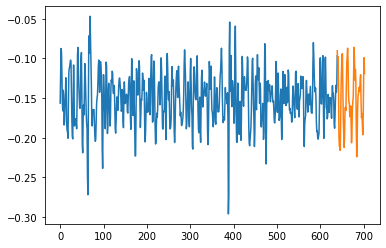

In [13]:
import matplotlib.pyplot as plt
plt.plot(inpt.T[:,0])
plt.plot(np.arange(window_size-1,window_size-1+target_length),tget.T[:,0])
plt.show()

In [14]:
o, h = model(rearrange(inpt,' a (b c) -> c b a',b=1).to(device))

In [15]:
o

tensor([[-0.1398, -0.1622, -0.1759,  ..., -0.1475, -0.1336, -0.1244],
        [-0.1401, -0.1651, -0.1591,  ..., -0.1460, -0.1557, -0.0989],
        [-0.1201, -0.1656, -0.1549,  ..., -0.1285, -0.1388, -0.1168],
        ...,
        [-0.1445, -0.1576, -0.1543,  ..., -0.1393, -0.1485, -0.1116],
        [-0.1229, -0.1654, -0.1595,  ..., -0.1452, -0.1454, -0.1062],
        [-0.1310, -0.1589, -0.1503,  ..., -0.1428, -0.1508, -0.1207]],
       device='cuda:0', grad_fn=<AddmmBackward>)

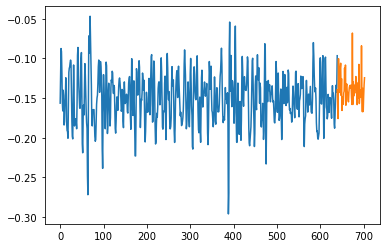

In [16]:
electrode = 0
plt.plot(inpt.T[:,electrode])
plt.plot(np.arange(window_size-1,window_size-1+target_length),o.cpu().detach().numpy()[electrode])
plt.show()

In [17]:

outputs = []
outputs.append(o)
for i in range(63):
    o,h = model(rearrange(o,' a (b c) -> c b a',b=1, c=1).to(device),h)
    print(o[0])
    outputs.append(o)

EinopsError:  Error while processing rearrange-reduction pattern " a (b c) -> c b a".
 Input tensor shape: torch.Size([32, 64]). Additional info: {'b': 1, 'c': 1}.
 Shape mismatch, 64 != 1

In [ ]:
prediction = torch.stack(outputs,axis=1).view(32,64)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(inpt.T[:,0])
plt.plot(np.arange(127,127+64),prediction[0].cpu().detach().numpy())
plt.show()